In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd
import joblib


In [2]:
df = pd.read_excel("Telco_customer_churn.xlsx")
print(df.shape)


(7043, 33)


In [3]:
print(df.columns)


Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')


In [4]:
# Drop unnecessary and leakage columns
drop_cols = [
    'CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
    'Lat Long', 'Latitude', 'Longitude',
    'Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'
]

df_clean = df.drop(columns=drop_cols)

print(df_clean.shape)


(7043, 20)


In [5]:
# =========================
# Fix Total Charges column
# =========================

df_clean["Total Charges"] = pd.to_numeric(
    df_clean["Total Charges"], 
    errors="coerce"
)

df_clean["Total Charges"] = df_clean["Total Charges"].fillna(
    df_clean["Total Charges"].median()
)

print("Remaining nulls:", df_clean["Total Charges"].isnull().sum())


Remaining nulls: 0


In [6]:
print(df_clean.columns)

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value'],
      dtype='object')


In [7]:
# =========================
# Basic Dataset Overview
# =========================

print("Shape of dataset:", df_clean.shape)
print("\nData Types:\n")
print(df_clean.dtypes)

print("\nMissing Values:\n")
print(df_clean.isnull().sum())


Shape of dataset: (7043, 20)

Data Types:

Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn Value            int64
dtype: object

Missing Values:

Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0


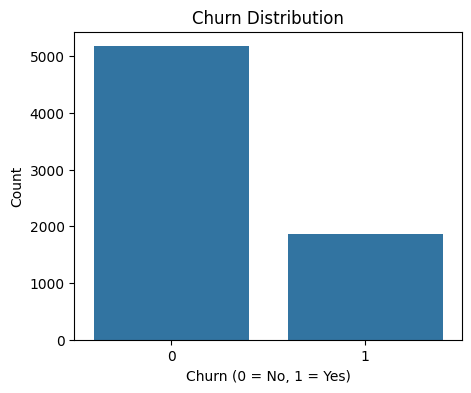


Churn Percentage:

Churn Value
0    73.463013
1    26.536987
Name: proportion, dtype: float64


In [8]:
#EDA
plt.figure(figsize=(5,4))
sns.countplot(x=df_clean["Churn Value"])
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Percentage view
churn_percentage = df_clean["Churn Value"].value_counts(normalize=True) * 100
print("\nChurn Percentage:\n")
print(churn_percentage)



In [9]:
#EDA
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns

print("\nNumerical Features Summary:\n")
print(df_clean[numerical_cols].describe())



Numerical Features Summary:

       Tenure Months  Monthly Charges  Total Charges  Churn Value
count    7043.000000      7043.000000    7043.000000  7043.000000
mean       32.371149        64.761692    2281.916928     0.265370
std        24.559481        30.090047    2265.270398     0.441561
min         0.000000        18.250000      18.800000     0.000000
25%         9.000000        35.500000     402.225000     0.000000
50%        29.000000        70.350000    1397.475000     0.000000
75%        55.000000        89.850000    3786.600000     1.000000
max        72.000000       118.750000    8684.800000     1.000000


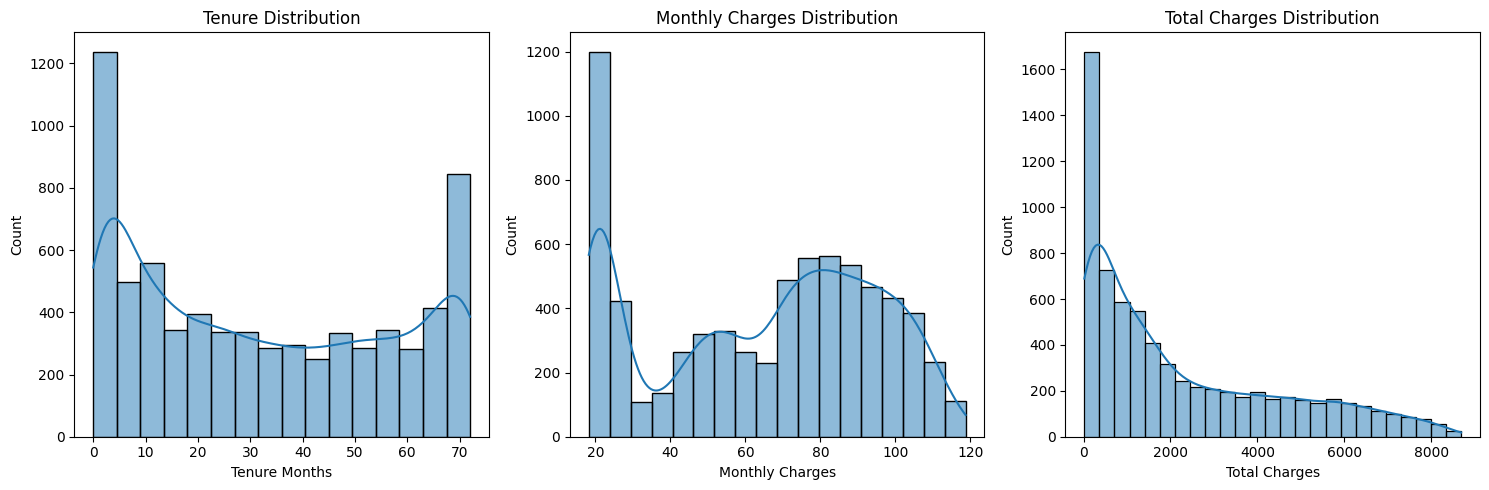

In [10]:
#EDA
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.histplot(df_clean["Tenure Months"], kde=True)
plt.title("Tenure Distribution")

plt.subplot(1,3,2)
sns.histplot(df_clean["Monthly Charges"], kde=True)
plt.title("Monthly Charges Distribution")

plt.subplot(1,3,3)
sns.histplot(df_clean["Total Charges"], kde=True)
plt.title("Total Charges Distribution")

plt.tight_layout()
plt.show()


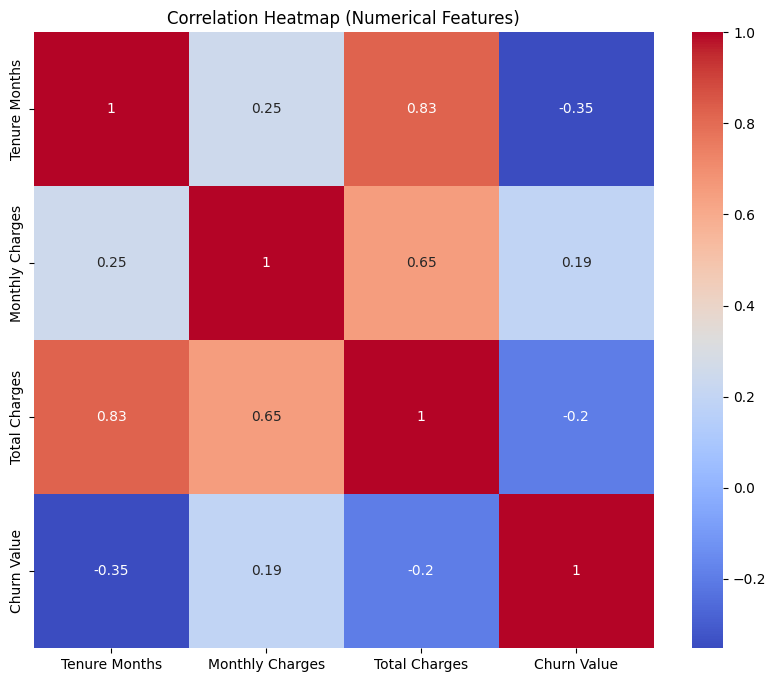

In [11]:
#EDA
plt.figure(figsize=(10,8))
sns.heatmap(df_clean[numerical_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


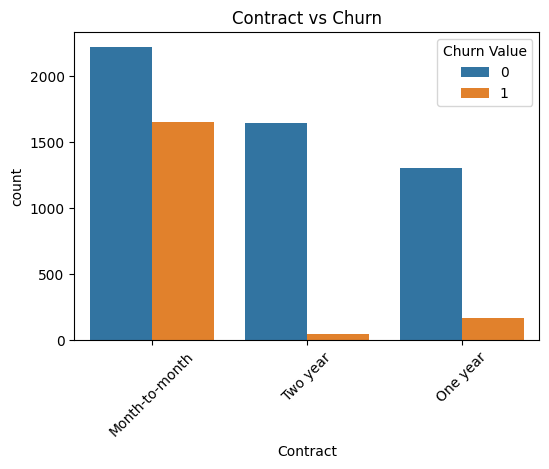

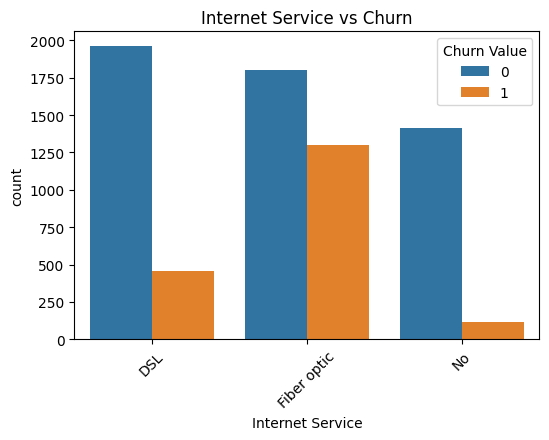

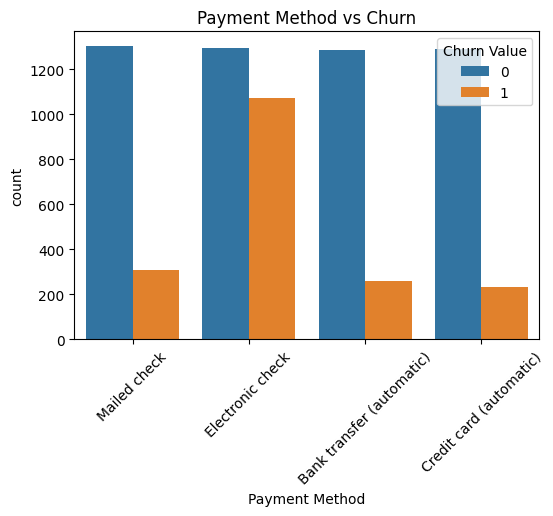

In [12]:
#EDA
categorical_cols = df_clean.select_dtypes(include=['object']).columns

# Example features
features_to_plot = ["Contract", "Internet Service", "Payment Method"]

for feature in features_to_plot:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df_clean, x=feature, hue="Churn Value")
    plt.xticks(rotation=45)
    plt.title(f"{feature} vs Churn")
    plt.show()


EDA Observations

Dataset contains 7043 instances and 19 features.

Churn distribution shows moderate class imbalance.

Customers with month-to-month contracts show higher churn.

Higher monthly charges appear correlated with churn.

Tenure is negatively correlated with churn (longer tenure - lower churn).

Numerical features show moderate correlation but no extreme multicollinearity.

In [14]:
#Separate X and y
X = df_clean.drop("Churn Value", axis=1)
y = df_clean["Churn Value"]

print(X.shape)
print(y.shape)


(7043, 19)
(7043,)


In [15]:
X_encoded = pd.get_dummies(X, drop_first=True)

print(X_encoded.shape)


(7043, 30)


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape)
print(X_test.shape)


(5634, 30)
(1409, 30)


In [17]:
# =========================
# Save Test CSV
# =========================

test_df = X_test.copy()
test_df["Churn Value"] = y_test

test_path = "/home/cloud/ML-Assignment-2-Telco-Churn/test_data.csv"
test_df.to_csv(test_path, index=False)

print("Test data saved at:", test_path)



Test data saved at: /home/cloud/ML-Assignment-2-Telco-Churn/test_data.csv


In [18]:
#Creating Scaled versions
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)


(5634, 30)
(1409, 30)


In [19]:
#Results Storage Dictionary
results = {}

In [20]:
#1. Logistic Regression (Scaled)
# Initialize model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train
log_reg.fit(X_train_scaled, y_train)

# Predict
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Compute metrics
results["Logistic Regression"] = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "AUC": roc_auc_score(y_test, y_prob_lr),
    "Precision": precision_score(y_test, y_pred_lr),
    "Recall": recall_score(y_test, y_pred_lr),
    "F1": f1_score(y_test, y_pred_lr),
    "MCC": matthews_corrcoef(y_test, y_pred_lr)
}

results["Logistic Regression"]


{'Accuracy': 0.7998580553584103,
 'AUC': 0.8484770983492211,
 'Precision': 0.6377245508982036,
 'Recall': 0.56951871657754,
 'F1': 0.6016949152542372,
 'MCC': 0.4699516071472934}

In [21]:
#2. Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

results["Decision Tree"] = {
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "AUC": roc_auc_score(y_test, y_prob_dt),
    "Precision": precision_score(y_test, y_pred_dt),
    "Recall": recall_score(y_test, y_pred_dt),
    "F1": f1_score(y_test, y_pred_dt),
    "MCC": matthews_corrcoef(y_test, y_pred_dt)
}

results["Decision Tree"]


{'Accuracy': 0.7295954577714692,
 'AUC': 0.6549407114624506,
 'Precision': 0.49076517150395776,
 'Recall': 0.49732620320855614,
 'F1': 0.4940239043824701,
 'MCC': 0.30954408165927483}

In [22]:
#3. K-Nearest Neighbor Classifier
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]

results["kNN"] = {
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "AUC": roc_auc_score(y_test, y_prob_knn),
    "Precision": precision_score(y_test, y_pred_knn),
    "Recall": recall_score(y_test, y_pred_knn),
    "F1": f1_score(y_test, y_pred_knn),
    "MCC": matthews_corrcoef(y_test, y_pred_knn)
}

results["kNN"]


{'Accuracy': 0.7608232789212207,
 'AUC': 0.7785618331654138,
 'Precision': 0.5509641873278237,
 'Recall': 0.5347593582887701,
 'F1': 0.5427408412483039,
 'MCC': 0.380926113606359}

In [23]:
#4. Naive Bayes Classifier - Gaussian
nb = GaussianNB()

nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)
y_prob_nb = nb.predict_proba(X_test)[:, 1]

results["Naive Bayes"] = {
    "Accuracy": accuracy_score(y_test, y_pred_nb),
    "AUC": roc_auc_score(y_test, y_prob_nb),
    "Precision": precision_score(y_test, y_pred_nb),
    "Recall": recall_score(y_test, y_pred_nb),
    "F1": f1_score(y_test, y_pred_nb),
    "MCC": matthews_corrcoef(y_test, y_pred_nb)
}

results["Naive Bayes"]


{'Accuracy': 0.6884315117104329,
 'AUC': 0.8164948719935932,
 'Precision': 0.4536376604850214,
 'Recall': 0.8502673796791443,
 'F1': 0.5916279069767442,
 'MCC': 0.42410143404258466}

In [24]:
#5. Ensemble Model - Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

results["Random Forest (Ensemble)"] = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "AUC": roc_auc_score(y_test, y_prob_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "MCC": matthews_corrcoef(y_test, y_pred_rf)
}

results["Random Forest (Ensemble)"]


{'Accuracy': 0.7899219304471257,
 'AUC': 0.83475935828877,
 'Precision': 0.625,
 'Recall': 0.5213903743315508,
 'F1': 0.5685131195335277,
 'MCC': 0.4342647955922759}

In [25]:
#!pip install xgboost


In [26]:
#6. Ensemble Model - XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

results["XGBoost (Ensemble)"] = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "AUC": roc_auc_score(y_test, y_prob_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1": f1_score(y_test, y_pred_xgb),
    "MCC": matthews_corrcoef(y_test, y_pred_xgb)
}

results["XGBoost (Ensemble)"]


{'Accuracy': 0.8055358410220014,
 'AUC': 0.8542225322276473,
 'Precision': 0.6612903225806451,
 'Recall': 0.5481283422459893,
 'F1': 0.5994152046783626,
 'MCC': 0.4761259838600907}

In [27]:
#Comparison Table
comparison_df = pd.DataFrame(results).T
comparison_df


,Accuracy,AUC,Precision,Recall,F1,MCC
Logistic Regression,0.799858,0.848477,0.637725,0.569519,0.601695,0.469952
Decision Tree,0.729595,0.654941,0.490765,0.497326,0.494024,0.309544
kNN,0.760823,0.778562,0.550964,0.534759,0.542741,0.380926
Naive Bayes,0.688432,0.816495,0.453638,0.850267,0.591628,0.424101
Random Forest (Ensemble),0.789922,0.834759,0.625000,0.521390,0.568513,0.434265
XGBoost (Ensemble),0.805536,0.854223,0.661290,0.548128,0.599415,0.476126


In [28]:
base_path = "/home/cloud/ML-Assignment-2-Telco-Churn/model"

joblib.dump(log_reg, f"{base_path}/logistic.pkl")
joblib.dump(dt, f"{base_path}/decision_tree.pkl")
joblib.dump(knn, f"{base_path}/knn.pkl")
joblib.dump(nb, f"{base_path}/naive_bayes.pkl")
joblib.dump(rf, f"{base_path}/random_forest.pkl")
joblib.dump(xgb, f"{base_path}/xgboost.pkl")
joblib.dump(scaler, f"{base_path}/scaler.pkl")

print("All models saved successfully.")


All models saved successfully.
